# Facenet Model Evaluation

In [1]:
import numpy as np

from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

Loading dataset

In [ ]:
data = np.load('./embedding/faces-embedding.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

print(len(X_train))
print(len(X_test))

in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

data = np.load('./embedding/faces-embedding-unknown.npz')
Xu_train, yu_train, Xu_test, yu_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

print(len(Xu_train))
print(len(Xu_test))

in_encoder = Normalizer(norm='l2')
Xu_train = in_encoder.transform(Xu_train)
Xu_test = in_encoder.transform(Xu_test)

155
310
420
860


Grid search for random forest hyperparameter tuning

In [3]:
rfc = RandomForestClassifier(random_state=42)
forest_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 9, 12],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [6, 9, 12]
  }
clf = GridSearchCV(rfc, forest_params, cv = 3, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_params_)

Class for model training (along with cosine similarity and euclidean distance comparison) but with probability threshold

In [4]:
class ModelProba:
  def __init__(self):
    self.svc_model = SVC(probability=True)
    self.rf_model = RandomForestClassifier(n_estimators=100, max_depth=9, max_features='log2', max_leaf_nodes=12, random_state=42)
  
  def eval_svc(self, X_train, y_train, X_test, y_test, thres):
    self.svc_model.fit(X_train, y_train)
    y_prob = self.svc_model.predict_proba(X_test)
    y_final = []

    for prob in y_prob:
      max_prob = np.max(prob)
      if max_prob >= thres:
        y_final.append(np.argmax(prob))
      else:
        y_final.append(len(prob)) # unknown

    score_test = accuracy_score(y_test, y_final)
    return score_test
  
  def eval_rf(self, X_train, y_train, X_test, y_test, thres):
    self.rf_model.fit(X_train, y_train)
    y_prob = self.rf_model.predict_proba(X_test)
    y_final = []

    for prob in y_prob:
      max_prob = np.max(prob)
      if max_prob >= thres:
        y_final.append(np.argmax(prob))
      else:
        y_final.append(len(prob)) # unknown

    score_test = accuracy_score(y_test, y_final)
    return score_test
  
  def cosine_similarity(self, A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return dot_product / (norm_A * norm_B)

  def recognize_face_cosine(self, embedding, embd, labels, threshold):
    name = np.max(labels)+1 # unknown
    min_dist = float("-inf")
    for embed, label in zip(embd, labels):
      dist = self.cosine_similarity(embedding, embed)
      if dist > min_dist:
          if dist > threshold:
            name = label
          min_dist = dist
    return name, min_dist

  def predict_test_cosine(self, train, t_label, test, thres):
    result = []
    for face in test:
      lab, dist = self.recognize_face_cosine(face, train, t_label, threshold=thres)
      result.append(lab)
    return result

  def recognize_face_euclidean(self, embedding, embd, labels, threshold):
    name = np.max(labels)+1 # unknown
    min_dist = float("inf")
    for embed, label in zip(embd, labels):
      dist = np.linalg.norm(embedding-embed)
      if dist < min_dist:
          if dist < threshold:
            name = label
          min_dist = dist
    return name, min_dist

  def predict_test_euclidean(self, train, t_label, test, thres):
    result = []
    for face in test:
      lab, dist = self.recognize_face_euclidean(face, train, t_label, threshold=thres)
      result.append(lab)
    return result
  
  def eval_cosine(self, X_train, y_train, X_test, y_test, thres):
    y_pred = self.predict_test_cosine(X_train, y_train, X_test, thres)
    score_test = accuracy_score(y_test, y_pred)
    return score_test
  
  def eval_euclidean(self, X_train, y_train, X_test, y_test, thres):
    y_pred = self.predict_test_euclidean(X_train, y_train, X_test, thres)
    score_test = accuracy_score(y_test, y_pred)
    return score_test


evaluator = ModelProba()

Fist we evaluate for face recognition task without unknown face, we can use the above class but set the threshold to zero for all model (since we do now need the threshold for unknown)

In [5]:
cosine_score = evaluator.eval_cosine(X_train, y_train, X_test, y_test, 0)
euclidean_score = evaluator.eval_euclidean(X_train, y_train, X_test, y_test, 1)
svc_score = evaluator.eval_svc(X_train, y_train, X_test, y_test, 0)
rf_score = evaluator.eval_rf(X_train, y_train, X_test, y_test, 0)

print(f"Accuracy for Cosine Similarity: {cosine_score}")
print(f"Accuracy for Euclidean Distance: {euclidean_score}")
print(f"Accuracy for SVC: {svc_score}")
print(f"Accuracy for Random Forest: {rf_score}")

Accuracy for Cosine Similarity: 0.9967741935483871
Accuracy for Euclidean Distance: 0.9935483870967742
Accuracy for SVC: 0.9935483870967742
Accuracy for Random Forest: 0.9516129032258065


Now we evaluate if we add unknown picture. In this dataset, half of the picture in original training data is removed, and the same label in validation is moved into "unknown" label.

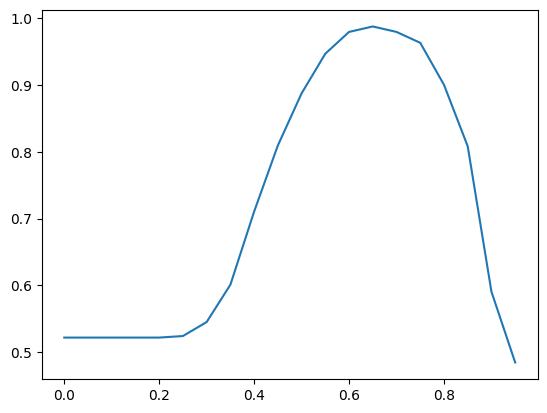

Best Accuracy for Cosine Similarity: 0.9872093023255814 at threshold 0.65


In [6]:
thres_list = []
acc_list = []

best_acc = 0
best_thres = -1
curr_thres = 0
for mult in range(20):
  score_test = evaluator.eval_cosine(Xu_train, yu_train, Xu_test, yu_test, curr_thres)

  if score_test > best_acc:
      best_acc = score_test
      best_thres = curr_thres

  thres_list.append(curr_thres)
  acc_list.append(score_test)
  curr_thres += 0.05
  
plt.plot(thres_list, acc_list)
plt.show()

print(f"Best Accuracy for Cosine Similarity: {best_acc} at threshold {round(best_thres, 2)}")

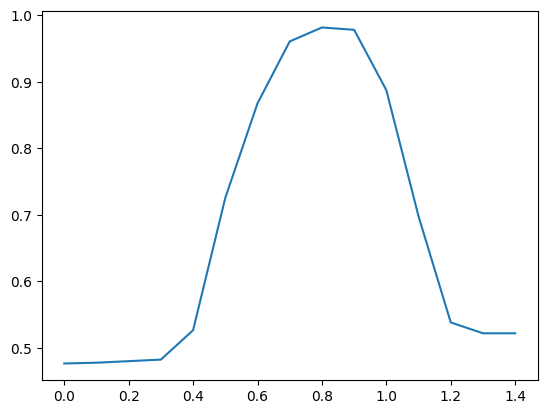

Best Accuracy for Euclidean Similarity: 0.9813953488372092 at threshold 0.8


In [7]:

thres_list = []
acc_list = []

best_acc = 0
best_thres = -1
curr_thres = 0
for mult in range(15):
  score_test = evaluator.eval_euclidean(Xu_train, yu_train, Xu_test, yu_test, curr_thres)

  if score_test > best_acc:
      best_acc = score_test
      best_thres = curr_thres

  thres_list.append(curr_thres)
  acc_list.append(score_test)
  curr_thres += 0.1
  
plt.plot(thres_list, acc_list)
plt.show()

print(f"Best Accuracy for Euclidean Similarity: {best_acc} at threshold {round(best_thres, 2)}")

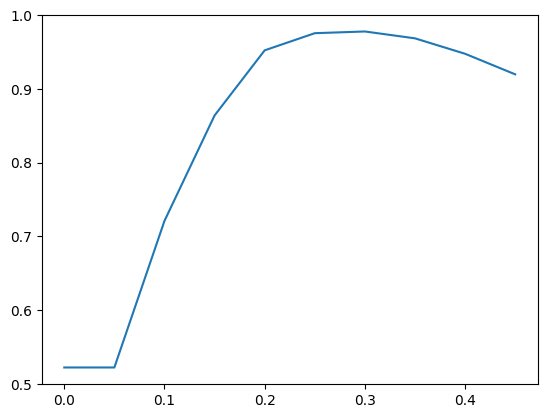

Best Accuracy for SVC: 0.977906976744186 at threshold 0.3


In [8]:
thres_list = []
acc_list = []

best_acc = 0
best_thres = -1
curr_thres = 0
for mult in range(10):
    score_test = evaluator.eval_svc(Xu_train, yu_train, Xu_test, yu_test, curr_thres)

    if score_test > best_acc:
        best_acc = score_test
        best_thres = curr_thres

    thres_list.append(curr_thres)
    acc_list.append(score_test)
    curr_thres += 0.05
  
plt.plot(thres_list, acc_list)
plt.show()

print(f"Best Accuracy for SVC: {best_acc} at threshold {round(best_thres, 2)}")

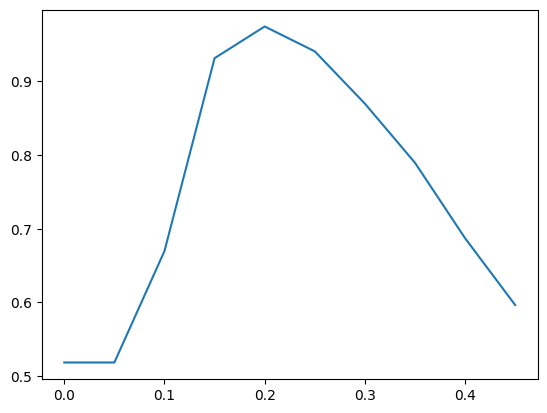

Best Accuracy for Random Forest: 0.9744186046511628 at threshold 0.5


In [9]:
thres_list = []
acc_list = []

best_acc = 0
best_thres = -1
curr_thres = 0
for mult in range(10):
    score_test = evaluator.eval_rf(Xu_train, yu_train, Xu_test, yu_test, curr_thres)

    if score_test > best_acc:
        best_thres = curr_thres
        best_acc = score_test

    thres_list.append(curr_thres)
    acc_list.append(score_test)
    curr_thres += 0.05
  
plt.plot(thres_list, acc_list)
plt.show()

print(f"Best Accuracy for Random Forest: {best_acc} at threshold {round(best_thres, 2)}")